<a href="https://colab.research.google.com/github/EslamKampoza/machine-intelligence-paper-/blob/main/Extrasensory_ITML_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

from utilize.data import *
from utilize.transform import *
from utilize.feature_selection import *
from utilize.test import *


Found 60 users data.


In [4]:
def score_function(y_test, y_pred, score = 'BA', W_test = None):

    mcm = []
    for i in range(y_test.shape[1]):
        if W_test is not None:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T, sample_weight = W_test[:,i].T)
        else:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T)
        cm = np.expand_dims(cm, axis = 0)
        mcm.append(cm)
    
    mcm = np.concatenate(mcm, axis = 0)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    BA = (sensitivity + specificity)/2
    accuracy = (tn + tp)/(tn + tp + fn + fp)

    sensitivity = np.sum(sensitivity)/sensitivity.shape[0]
    specificity = np.sum(specificity)/specificity.shape[0]
    BA = np.sum(BA)/BA.shape[0]
    accuracy = np.sum(accuracy)/accuracy.shape[0]

    if score == 'BA': 
        return BA
    else: 
        raise Exception('score not valid!')

In [5]:
# Load all the data from Extrasenory dataset
X, y, M, user_index, feature_names, label_names = load_all_data()

In [6]:
feature_index = [ 0,   1,   2,   4,   6,   7,   9,  12,  13,  16,  17,  18,  19,
        20,  22,  23,  24,  25,  26,  27,  28,  31,  32,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  49,  52,  53,
        54,  56,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,  71,
        72,  73,  74,  76,  77,  78,  79,  80,  81,  85,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 119, 120,
       121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 154, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 170, 171, 172, 173, 176, 177, 178, 180, 181, 182, 183,
       185, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198, 199, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 224]
X175 = X[:, feature_index]

In [7]:
# Only select body state label
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
#target_label = ["SITTING"]
# Use the last 5 user's data as test set
#test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X175, y, M, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test, M_train, M_test = train_test_split(X_new, y_new, M_new, test_size = 0.2)

In [9]:
# To swap 0 and 1, simply do 
y_train_sampleweight = np.abs(1-M_train)

y_train_sw1D = np.zeros(y_train_sampleweight.shape[0])
for i in range(len(y_train_sw1D)):
    y_train_sw1D[i] = np.sum(y_train_sampleweight[i])/M_train.shape[1]

# To swap 0 and 1, simply do 
y_test_sampleweight = np.abs(1-M_test)

y_test_sw1D = np.zeros(y_test_sampleweight.shape[0])
for i in range(len(y_test_sw1D)):
    y_test_sw1D[i] = np.sum(y_test_sampleweight[i])/M_test.shape[1]

In [10]:
y_train11 = y_train_sw1D.reshape(len(y_train_sw1D),1)
y_test11 = y_test_sw1D.reshape(len(y_test_sw1D),1)

In [11]:
y_test1 = []
new_test_Data1 = []
for i in range(len(y_test)):
    for j in range(y_test.shape[1]):
        if y_test[i,j]:
             y_test1.append(j)
             new_test_Data1.append(X_test[i])

In [12]:
y_train1 = []
new_train_Data1 = []
for i in range(len(y_train)):
    for j in range(y_train.shape[1]):
        if y_train[i,j]:
             y_train1.append(j)
             new_train_Data1.append(X_train[i])

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler , MinMaxScaler

In [14]:
scaler = MinMaxScaler()
scaler.fit(new_train_Data1)
X_train = scaler.transform(new_train_Data1)
X_test = scaler.transform(new_test_Data1)

In [15]:
#encoding Labels

encoder = LabelEncoder()

#encoding test labels

encoder.fit(y_test1)
new_test_labels = encoder.transform(y_test1)

#encoding train labels

encoder.fit(y_train1)
new_train_labels = encoder.transform(y_train1)

In [16]:
from matplotlib import pyplot
def plot_confusion_matrix (cm, classes, normalize=False, title='Confusion Matrix', cmap=pyplot.cm.Blues,
                           decsnTreeClf=None):
    #This function prints and plots the confusion matrix.
    pyplot.imshow(cm,interpolation='nearest',cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks=np.arange(len(classes))
    pyplot.xticks(tick_marks,classes,rotation=45)
    pyplot.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j,i,cm[i,j],horizontalalignment="center", color="white" if cm[i,j]> thresh else "black" )

    pyplot.tight_layout()
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')
    pyplot.show()


In [17]:
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [18]:
from sklearn.decomposition import PCA
pca= PCA(0.9) # capture the %85 of the variance
pca.fit(X_train)
newx_train=pca.transform(X_train)
newx_test=pca.transform(X_test)

In [19]:
!pip install metric-learn
import metric_learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
mmc = metric_learn.ITML_Supervised()
X_mmc = mmc.fit(newx_train,new_train_labels)

/usr/local/lib/python3.8/dist-packages/metric_learn/itml.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack({tuple(row) for row in pairs.reshape(-1, pairs.shape[2])})


In [21]:
X_train.shape
MM = mmc.get_mahalanobis_matrix()
MM.shape

(37, 37)

In [22]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import math
from random import randint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA




class Smote(object):
	"""docstring for Smote"""

	def __init__(self,distance,MM):
		super(Smote, self).__init__()
		self.synthetic_arr=  []
		self.newindex = 0
		self.distance_measure = distance
		self.mmc = MM       



	def Populate(self,N,i,indices,min_samples,k):
		"""
    		Populates the synthitic array


    		Returns:Synthetic Array to generate_syntheic_points 
    	"""

		while N!=0:
			arr = []
			nn = randint(0,k-2)
			features = len(min_samples[0])
			
			for attr in range(features):
				diff = min_samples[indices[nn]][attr] - min_samples[i][attr]
				gap = random.uniform(0,1)
				arr.append(min_samples[i][attr] + gap*diff)
			
			self.synthetic_arr.append(arr)
			self.newindex = self.newindex + 1
			N = N-1



	def k_neighbors(self,euclid_distance,k):
		nearest_idx_npy = np.empty([euclid_distance.shape[0],euclid_distance.shape[0]],dtype=np.int64)
		
		for i in range(len(euclid_distance)):
			idx = np.argsort(euclid_distance[i])
			nearest_idx_npy[i] = idx
			idx = 0

		return nearest_idx_npy[:,1:k]




	def find_k(self,X,k):

		"""
   			Finds k nearest neighbors using euclidian distance

   			Returns: The k nearest neighbor   
    	"""




		euclid_distance = np.empty([X.shape[0],X.shape[0]],dtype = np.float32)
		
		for i in range(len(X)):
			dist_arr = []
			for j in range(len(X)):
				dist_arr.append(math.sqrt(sum((X[j]-X[i])**2)))
			dist_arr = np.asarray(dist_arr,dtype = np.float32)
			euclid_distance[i] = dist_arr

		return self.k_neighbors(euclid_distance,k)






	def generate_synthetic_points(self,min_samples,N,k):

		"""
    		Returns (N/100) * n_minority_samples synthetic minority samples.
    		Parameters
    		----------
    		min_samples : Numpy_array-like, shape = [n_minority_samples, n_features]
    		    Holds the minority samples
    		N : percetange of new synthetic samples: 
    		    n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    		k : int. Number of nearest neighbours. 
    		Returns
    		-------
    		S : Synthetic samples. array, 
    		    shape = [(N/100) * n_minority_samples, n_features]. 
    	"""
		

		if N < 100:
			raise ValueError("Value of N cannot be less than 100%")

		if self.distance_measure not in ('euclidian','ball_tree','Mahal'):
			raise ValueError("Invalid Distance Measure.You can use only Euclidian or ball_tree")


		if k>min_samples.shape[0]:
			raise ValueError("Size of k cannot exceed the number of samples.")

		
		N = int(N/100)
		T = min_samples.shape[0]
		
		

		if self.distance_measure == 'euclidian':
				indices = self.find_k(min_samples,k)
			
		elif self.distance_measure=='ball_tree':
			nb = NearestNeighbors(n_neighbors = k,algorithm= 'ball_tree').fit(min_samples)
			distance,indices = nb.kneighbors(min_samples)
			indices = indices[:,1:]	
		elif self.distance_measure=='Mahal':
			nb = NearestNeighbors(n_neighbors = k,metric = mmc.get_metric()).fit(min_samples)
			distance,indices = nb.kneighbors(min_samples)
			indices = indices[:,1:]	


		for i in range(indices.shape[0]):
			self.Populate(N,i,indices[i],min_samples,k)
		
		return np.asarray(self.synthetic_arr)

		


	def plot_synthetic_points(self,min_samples,N,k):
		"""

			Plot the over sampled synthtic samples in a scatterplot



		"""


		if N < 100:
			raise ValueError("Value of N cannot be less than 100%")

		if self.distance_measure not in ('euclidian','ball_tree','Mahal'):
			raise ValueError("Invalid Distance Measure.You can use only Euclidian or ball_tree")


		if k>min_samples.shape[0]:
			raise ValueError("Size of k cannot exceed the number of samples.")

		
		synthetic_points = self.generate_synthetic_points(min_samples,N,k)
		
		pca = PCA(n_components=2)
		pca.fit(synthetic_points)
		pca_synthetic_points = pca.transform(synthetic_points)
		
		plt.scatter(pca_synthetic_points[:,0],pca_synthetic_points[:,1])
		plt.show()

In [23]:
trainLabel = new_train_labels.reshape(len(new_train_labels),1)
train = np.hstack((newx_train, trainLabel))

In [24]:
unique,counts = np.unique(trainLabel,return_counts = True)
dict(zip(unique,counts))

{0: 83313, 1: 109126, 2: 17700, 3: 868, 4: 4017, 5: 30332}

In [33]:
mask = train[:,37] == 0
class0 = train[mask]
class0 = class0[0:600,:37]
N = 108830*100/600
k = 12
class0 = np.float_(class0)
smote_test1 = Smote('Mahal',mmc)
new_class0 = smote_test1.generate_synthetic_points(class0[:,:37],N,k)

myclass = np.array([0 for x in range(len(new_class0))])
#myclass = ["Standing" for x in range(1500)]
myclass = myclass.reshape(len(new_class0),1)
new_class0 = np.hstack((new_class0[:,:37],myclass))

In [44]:
mask = train[:,37] == 2
class2 = train[mask]
class2 = class2[0:600,:37]
N = 108830*100/600
#(8356-4445) * 100/4445
k = 12
class2 = np.float_(class2)
smote_test1 = Smote('Mahal',mmc)
new_class2 = smote_test1.generate_synthetic_points(class2[:,:37],N,k)

myclass = np.array([2 for x in range(len(new_class2))])
#myclass = ["Standing" for x in range(1500)]
myclass = myclass.reshape(len(new_class2),1)
new_class2 = np.hstack((new_class2[:,:37],myclass))

In [35]:
mask = train[:,37] == 3
class3 = train[mask]
class3 = class3[:,:37]
N = 108830*100/874
#(8356-4445) * 100/4445
k = 12
class3 = np.float_(class3)
smote_test1 = Smote('Mahal',mmc)
new_class3 = smote_test1.generate_synthetic_points(class3[:,:37],N,k)

myclass = np.array([3 for x in range(len(new_class3))])
#myclass = ["Standing" for x in range(1500)]
myclass = myclass.reshape(len(new_class3),1)
new_class3 = np.hstack((new_class3[:,:37],myclass))

In [45]:
new_class2.shape

(108600, 38)

In [37]:
mask = train[:,37] == 4
class4 = train[mask]
class4 = class4[:,:37]
N = 108830*100/4017
#(8356-4445) * 100/4445
k = 12
class4 = np.float_(class3)
smote_test1 = Smote('Mahal',mmc)
new_class4 = smote_test1.generate_synthetic_points(class4[:,:37],N,k)

myclass = np.array([4 for x in range(len(new_class4))])
#myclass = ["Standing" for x in range(1500)]
myclass = myclass.reshape(len(new_class4),1)
new_class4 = np.hstack((new_class4[:,:37],myclass))

In [46]:
mask = train[:,37] == 5
class5 = train[mask]
class5 = class5[0:600,:37]
N = 108830*100/600
#(8356-4445) * 100/4445
k = 12
class5 = np.float_(class5)
smote_test1 = Smote('Mahal',mmc)
new_class5 = smote_test1.generate_synthetic_points(class5[:,:37],N,k)

myclass = np.array([5 for x in range(len(new_class5))])
#myclass = ["Standing" for x in range(1500)]
myclass = myclass.reshape(len(new_class5),1)
new_class5 = np.hstack((new_class5[:,:37],myclass))

In [47]:
new_train_data = []
new_train_data = np.concatenate((newx_train, new_class0[:,:37]), axis=0)
new_train_data = np.concatenate((new_train_data, new_class2[:,:37]), axis=0)
new_train_data = np.concatenate((new_train_data, new_class3[:,:37]), axis=0)
new_train_data = np.concatenate((new_train_data, new_class4[:,:37]), axis=0)
new_train_data = np.concatenate((new_train_data, new_class5[:,:37]), axis=0)

In [48]:
new_train_labels= []
new_train_labels = np.concatenate((trainLabel, new_class0[:,-1].reshape(len(new_class0[:,-1]),1)), axis=0)
new_train_labels = np.concatenate((new_train_labels, new_class2[:,-1].reshape(len(new_class2[:,-1]),1)), axis=0)
new_train_labels = np.concatenate((new_train_labels, new_class3[:,-1].reshape(len(new_class3[:,-1]),1)), axis=0)
new_train_labels = np.concatenate((new_train_labels, new_class4[:,-1].reshape(len(new_class4[:,-1]),1)), axis=0)
new_train_labels = np.concatenate((new_train_labels, new_class5[:,-1].reshape(len(new_class5[:,-1]),1)), axis=0)

In [49]:
unique,counts = np.unique(new_train_labels,return_counts = True)
dict(zip(unique,counts))

{0.0: 191913, 1.0: 109126, 2.0: 126300, 3.0: 108500, 4.0: 27453, 5.0: 138932}

In [50]:
Data_res = new_train_data
labels_res = new_train_labels
testLabelE = new_test_labels

In [ ]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
clf2= KNeighborsClassifier(n_neighbors=4, metric = mmc.get_metric())
knnModel2 = clf2.fit(Data_res,labels_res)
y_te_pred2 = clf2.predict(newx_test)

acc2 = accuracy_score(testLabelE,y_te_pred2)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(testLabelE,y_te_pred2)
pyplot.figure()

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Confusion matrix, without normalization
[[19926   688    64     9     5   205]
 [ 1105 23755   881   122    64  1303]
 [  112  1090  2663   118    32   421]
 [    1    13    13   186     4     5]
 [   10   139   113    16   667    58]
 [  348  2008   577    59    33  4425]]


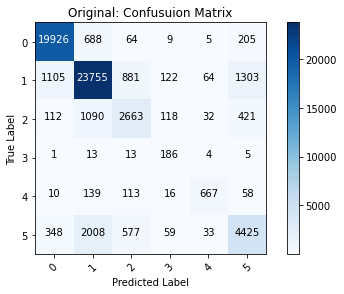

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     20897
           1       0.86      0.87      0.87     27230
           2       0.62      0.60      0.61      4436
           3       0.36      0.84      0.51       222
           4       0.83      0.67      0.74      1003
           5       0.69      0.59      0.64      7450

    accuracy                           0.84     61238
   macro avg       0.71      0.75      0.72     61238
weighted avg       0.84      0.84      0.84     61238



In [52]:
import itertools
from sklearn.metrics import classification_report
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(testLabelE,y_te_pred2))

In [72]:
sm = SMOTE(random_state = 2)
Data_res,labels_res = sm.fit_resample(X_train,new_train_labels)

In [73]:
unique,counts = np.unique(labels_res,return_counts = True)
dict(zip(unique,counts))

{0: 108984, 1: 108984, 2: 108984, 3: 108984, 4: 108984, 5: 108984}

In [74]:
clf2= KNeighborsClassifier(n_neighbors=4)
knnModel2 = clf2.fit(Data_res,labels_res)

In [75]:
X_test.shape

(61515, 175)

In [76]:
unique,counts = np.unique(new_test_labels,return_counts = True)
dict(zip(unique,counts))

{0: 21104, 1: 27372, 2: 4485, 3: 203, 4: 931, 5: 7420}

K-Nearest Neighbors Accuracy: 0.84469
Confusion matrix, without normalization
[[20239   334   171     5    17   338]
 [  966 21551  1976    82   377  2420]
 [   42   317  3556    32   117   421]
 [    1     6    26   162     2     6]
 [    2    27    61     2   808    31]
 [  193   691   707    27   157  5645]]


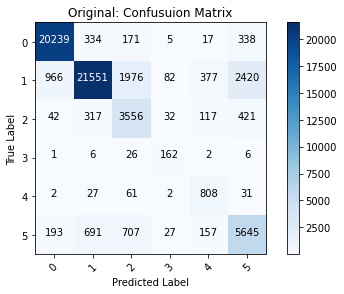

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     21104
           1       0.94      0.79      0.86     27372
           2       0.55      0.79      0.65      4485
           3       0.52      0.80      0.63       203
           4       0.55      0.87      0.67       931
           5       0.64      0.76      0.69      7420

    accuracy                           0.84     61515
   macro avg       0.69      0.83      0.74     61515
weighted avg       0.87      0.84      0.85     61515



In [77]:
import itertools
from sklearn.metrics import classification_report
y_te_pred2 = clf2.predict(X_test)#[1:10000,:])

acc2 = accuracy_score(new_test_labels,y_te_pred2)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(new_test_labels,y_te_pred2)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(new_test_labels,y_te_pred2))

In [1]:
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
plot_confusion_matrix(cfs,classes=target_label,title="Original: Confusuion Matrix")

NameError: ignored